In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
def f(x, weights):
    return np.matmul(weights.transpose(),x)

def prop_dist(weights, S):
    return np.random.multivariate_normal(weights.reshape(1,-1)[0], S).reshape(-1,1)

def feature_space(x):
    return np.array([1,x[0]])

def get_A(X, error_sigma, cov_inverse):
    return X*X.transpose()/error_sigma**2+cov_inverse

def get_w_bar(A, X, y, error_sigma):
    return np.matmul((1/error_sigma**2)*np.linalg.inv(A), x*y)

def get_posterior(w, X, y, error_sigma, cov_inverse):
    A = get_A(X, error_sigma, cov_inverse)
    w_bar = get_w_bar(A, X, y, error_sigma)
    
    return -0.5*np.matmul((w-w_bar).transpose(),np.matmul(A,(w-w_bar)))

def MCMC(M, cov, x, y, start, error_sigma, cov_inverse):
    # step count
    N = 1

    # accepted sample count
    N_samples = 0
    
    curr_weights = start
    
    # calculate prev_ration for the starting position
    prev_posterior = get_posterior(curr_weights, x, y, error_sigma, cov_inverse)

    while N_samples < M:
        # new proposal point
        prop_weights = prop_dist(curr_weights, cov)

        # log of posterior distribution
        posterior = get_posterior(prop_weights, x, y, error_sigma, cov_inverse)
        
        # log of accept prob
        accept_prob = min(0, posterior-prev_posterior)

        # see if we accept new point
        if np.log(np.random.rand()) < accept_prob:
            # change current state of MC
            curr_weights = prop_weights
            prev_posterior = posterior
            N_samples += 1
        
    return curr_weights, N

In [3]:
sigma_error = 0.05

In [4]:
data = [(-2,-1), (-1,-0.1), (0,0.2), (1,0.1), (2,0.5)]

In [5]:
x=[]
y=[]
for datapoint in data:
    x.append(datapoint[0])
    y.append(datapoint[1])
    
#vectorize
x = np.array(x).reshape(-1,1)
y = np.array(y).reshape(-1,1)

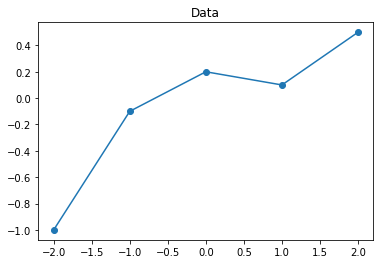

In [8]:
plt.plot(x,y, marker = 'o')
plt.title('Data')
plt.show()

In [ ]:
# Eqn 2.8

In [391]:
# D / X
design_matrix = np.ones((5,2))
design_matrix[:, 1] = x[:,0]
design_matrix = design_matrix.T

In [392]:
design_matrix

array([[ 1.,  1.,  1.,  1.,  1.],
       [-2., -1.,  0.,  1.,  2.]])

In [359]:
#kernel = np.identity(len(x))
kernel = np.identity(2)

In [360]:
#A = 1/(sigma_error**2) * design_matrix @ design_matrix.T + kernel
A = 1/(sigma_error**2) * design_matrix @ design_matrix.T + kernel
Ainv = np.linalg.inv(A)

In [361]:
weight_bar = 1/(sigma_error**2) * (Ainv @ (design_matrix @ y))

In [362]:
weight_bar

array([[-0.05997001],
       [ 0.31992002]])

In [367]:
weights = np.random.multivariate_normal(np.hstack(weight_bar), Ainv)
ybar = weights[0] * 1 + weights[1] * x

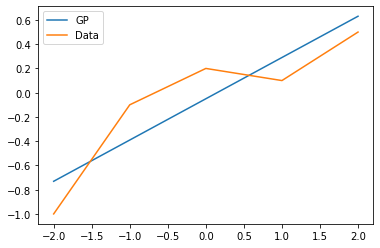

In [368]:
plt.plot(x, ybar, label = 'GP')
plt.plot(x, y, label = 'Data')
plt.legend()
plt.show()

In [157]:
def linear_phi(x):
    return np.array([1,x])

def quadratic_phi(x):
    return np.array([1,x,x**2])

In [400]:
class Gaussian_Process():
    def __init__(self,x, y, sigma_error, N, kernel=None):
        self.y = y
        self.x = x
        self.N = N
        self.sigma_error = sigma_error
        if kernel:
            self.kernel = kernel
        else:
            self.kernel = np.identity(self.N)

        self.trained=False

    def phi(self, x):
        return np.array([x**i for i in range(N)])
        
    def build_design_matrix(self):
        
        self.design_matrix = np.ones((self.N, len(self.x)))
        for column in range(len(self.x)):
            self.design_matrix[:,column] = self.phi(self.x[column][0])
            
    def build_A(self):
        self.A = 1/(self.sigma_error**2) * self.design_matrix @ self.design_matrix.T + self.kernel
        self.Ainv = np.linalg.inv(self.A)
    
    def build_w_bar(self):
        self.weight_bar = 1/(self.sigma_error**2) * (self.Ainv @ (self.design_matrix @ self.y))
    
    def train_x(self):
        self.trained=True
        self.build_design_matrix()
        self.build_A()
        self.build_w_bar()
        
    def get_sample(self):
        #TODO: add to make 
        assert self.trained==True, 'train first'
        self.weights = np.random.multivariate_normal(np.hstack(self.weight_bar), self.Ainv)
        
        self.ybar = np.zeros(self.y.shape)
        for i in range(self.N):
            self.ybar += self.weights[i] * self.x**i 
        
        #self.ybar+= np.random.normal(0, self.sigma_error)
            

In [409]:
N=4
data = []
gp = Gaussian_Process(x,y,sigma_error, N)
gp.train_x()

for ii in range(30):
    
    gp.get_sample()
    data.append(gp.ybar)

In [413]:
data = np.array(data)
means = []
stds = []
for ii in range(len(data.T[0])):
    means.append(np.mean(data.T[0][ii]))
    stds.append(np.std(data.T[0][ii]))

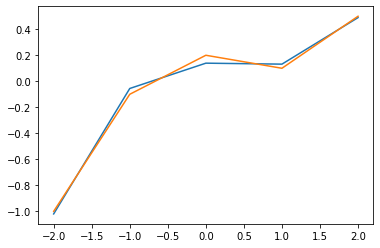

In [411]:
plt.plot(x, means)
plt.plot(x,y, label = 'data')

TypeError: unsupported operand type(s) for -: 'list' and 'list'

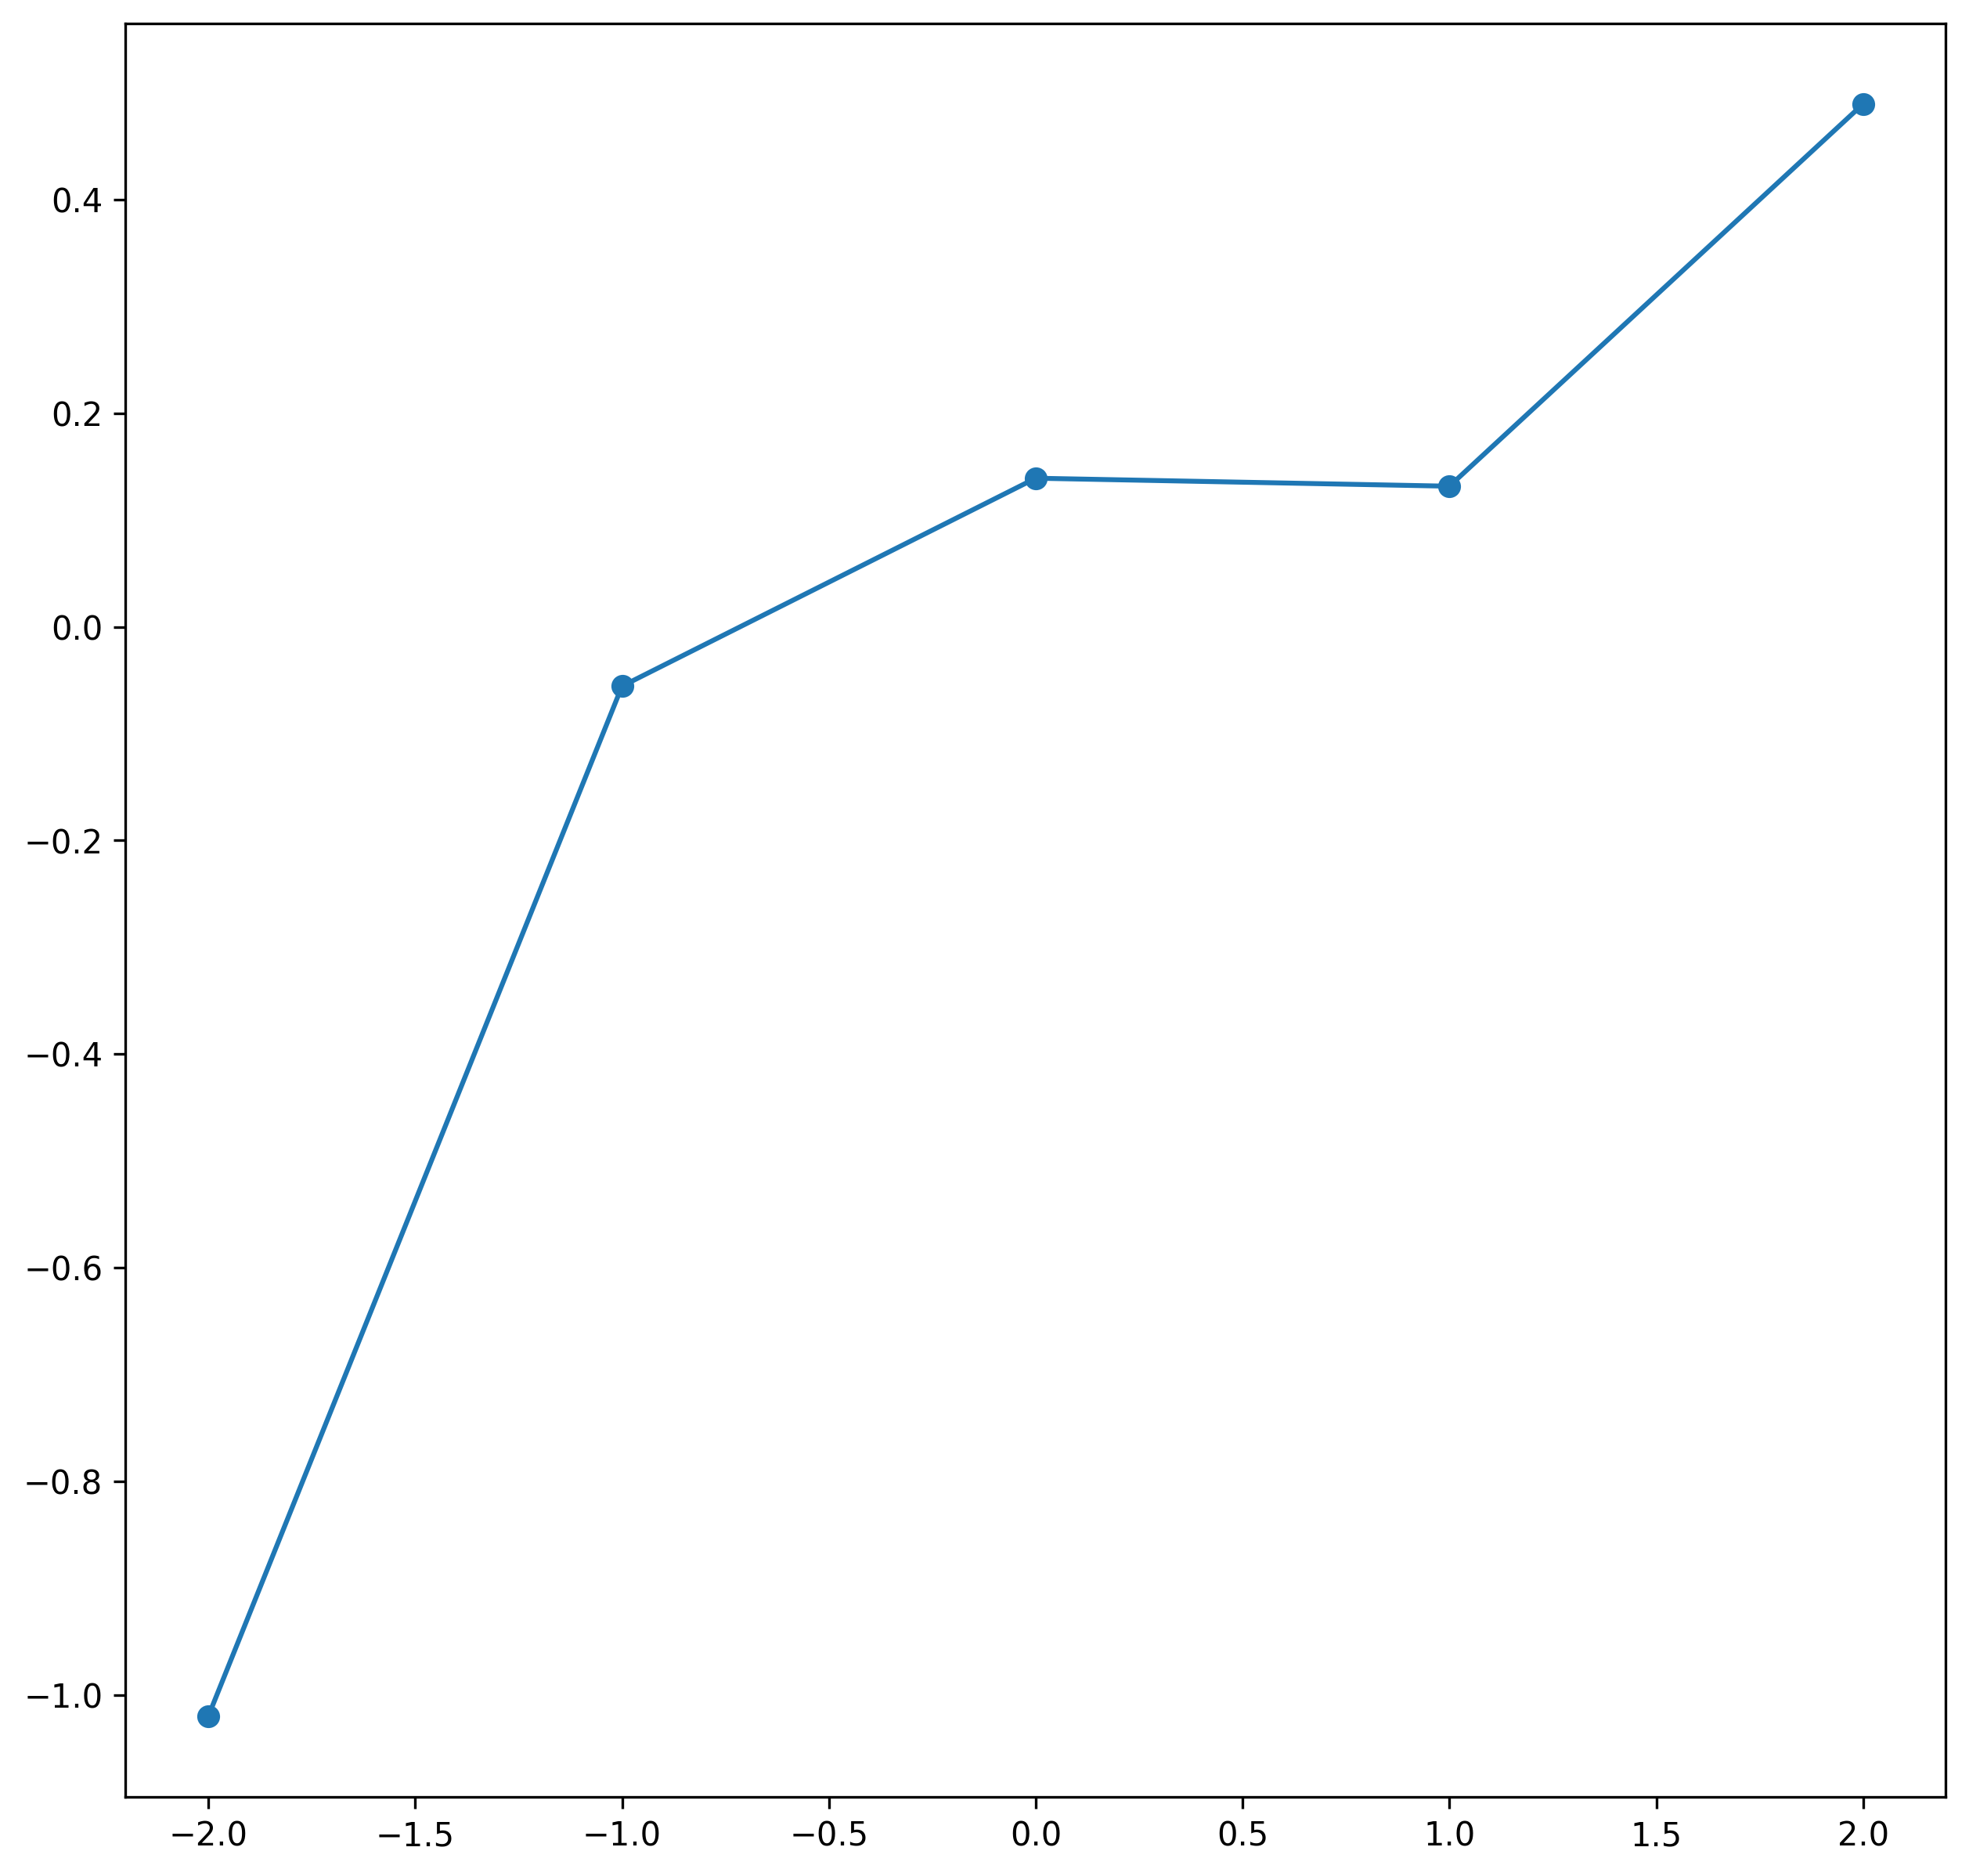

In [414]:
plt.figure(figsize = (10,10), dpi = 300)
plt.plot(x, means, label = 'NN', marker = 'o')
plt.fill_between(x, (np.array(means) - np.array(stds)), (np.array(means) + stds), color = 'b', alpha = .1,
                label = 'CI Longstaff-Schwarz')

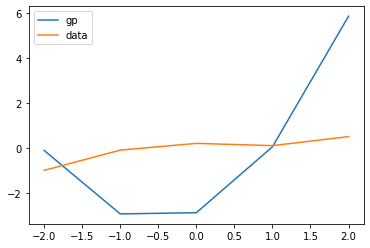

In [324]:
gp.get_sample()
plt.plot(gp.x,gp.ybar, label = 'gp')
plt.plot(x,y, label = 'data')
plt.legend()